# Dubinska analiza podataka - projektni zadatak

## 1. Predprocesiranje podataka

In [147]:
# Ovo je tu jer ponekad zna prvu liniju u svakoj čeliji označit kao grešku makar sve radi,
# ali me živcira to podcrtano. Pa treba ovo pokrenut, pa se od VS coda izbaci da se treba
# instalirati 'languagepack' pa onda zatvorit i opet otvorit .ipynb file i nema više podcrtanog

# lintr::use_lintr(type = "tidyverse")

In [2]:
library(tidyr)
library(dplyr)
library(caret)
library(neuralnet)
library(randomForest)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'neuralnet'


The following object is masked from 'package:dplyr':

    compute


Loading required package: ggplot2

Loading required package: lattice



In [106]:
# Importing data and displaying the internal structure
phoneData <- read.csv('phone_specs.csv')

str(phoneData)

'data.frame':	1359 obs. of  22 variables:
 $ Index          : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Name           : chr  "OnePlus 7T Pro McLaren Edition" "Realme X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ Brand          : chr  "OnePlus" "Realme" "Apple" "Apple" ...
 $ Model          : chr  "7T Pro McLaren Edition" "X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ BatteryCapacity: int  4085 4000 3969 3110 4000 3800 4085 4300 6000 4000 ...
 $ ScreenSize     : num  6.67 6.5 6.5 6.1 6.4 6.55 6.67 6.8 6.59 6.39 ...
 $ Touchscreen    : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ ResolutionX    : int  1440 1080 1242 828 1080 1080 1440 1440 1080 1080 ...
 $ ResolutionY    : int  3120 2400 2688 1792 2340 2400 3120 3040 2340 2340 ...
 $ Processor      : int  8 8 6 6 8 8 8 8 8 8 ...
 $ RAM            : int  12000 6000 4000 4000 6000 8000 8000 12000 8000 6000 ...
 $ InternalStorage: num  256 64 64 64 128 128 256 256 128 128 ...
 $ RearCamera     : num  48 64 12 12 12 48 48 12 48 48 ...
 $ FrontCamera    : nu

In [4]:
# OS data with name and frequency 
table(phoneData$OS)


   Android BlackBerry   Cyanogen        iOS   Sailfish      Tizen    Windows 
      1299         10         10         17          1          3         19 

In [108]:
phoneData <- phoneData %>%
    filter(!(OS == 'Sailfish' | OS == 'Tizen')) %>%                       # delete rows with less know OS (only 3 rows) because One-hot-encoding
    mutate(value = 1) %>% spread(OS, value,  fill = 0 ) %>%               # One-hot-encoding OS column
    mutate(Price = round(Price / 87.95)) %>%                              # convert price (indian rupee to euro)
    mutate(PriceCategory = ifelse(Price <= 200, 'Low-End',
                           ifelse(Price <= 500, 'Mid-Range', 'High-End'))) %>%      # Defining price categories
    filter(!(PriceCategory == 'Low-End' & RearCamera >= 20)) %>%
    filter(!(PriceCategory == 'Low-End' & FrontCamera >= 10)) %>%
    filter(!(PriceCategory == 'Low-End' & RAM > 4000)) %>%
    filter(!(PriceCategory == 'Low-End' & InternalStorage > 64))          # Filtering some data to get better accuracy

In [6]:
names(phoneData)

[1] "Index"           "Name"            "Brand"           "Model"          
 [5] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [9] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
[13] "RearCamera"      "FrontCamera"     "WiFi"            "Bluetooth"      
[17] "GPS"             "SIMsNumber"      "X3G"             "X4G.LTE"        
[21] "Price"           "Android"         "BlackBerry"      "Cyanogen"       
[25] "iOS"             "Windows"         "PriceCategory"

In [109]:
# Removing columns that are not used for traning (Index, Name, Brand, Model and Price)
phoneData <- phoneData[-c(1:4, 21)]

In [8]:
table(phoneData$PriceCategory)


 High-End   Low-End Mid-Range 
       49       977       144 

## 2. Klasifikacija - umjetne neuronske mreže

In [ ]:
# Neuralnet requires normalized data and accepts only numerical values as input
phoneData_nn <- phoneData %>%
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE), ~as.numeric(ifelse(.x == 'Yes', 1, 0)))) %>%    # convert categorical Yes/No to 1/0 
    mutate(across(c(5, 6, 8:14, 18), scale))                                                                          # normalization with scale() for numeric data

#### Prvi ANN model --> nauralnet paket

In [9]:
# First ANN model with neuralnet package
set.seed(123)

trainIndex = createDataPartition(phoneData_nn$PriceCategory, p = 0.75, list = FALSE)
trainData <- phoneData_nn[trainIndex, ]
testData <- phoneData_nn[-trainIndex, ] 

nn = neuralnet(PriceCategory ~ .,
                data = trainData,
                hidden = 14,
                lifesign = 'full',
                linear.output = FALSE)

hidden: 14    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.0996231409036611
                                                 
   2000	min thresh: 0.0546513793901923
                                                 
   3000	min thresh: 0.0253587093223993
                                                 
   4000	min thresh: 0.0108831842964161
                                                 
   4092
	error: 14.20329
	time: 12.47 secs



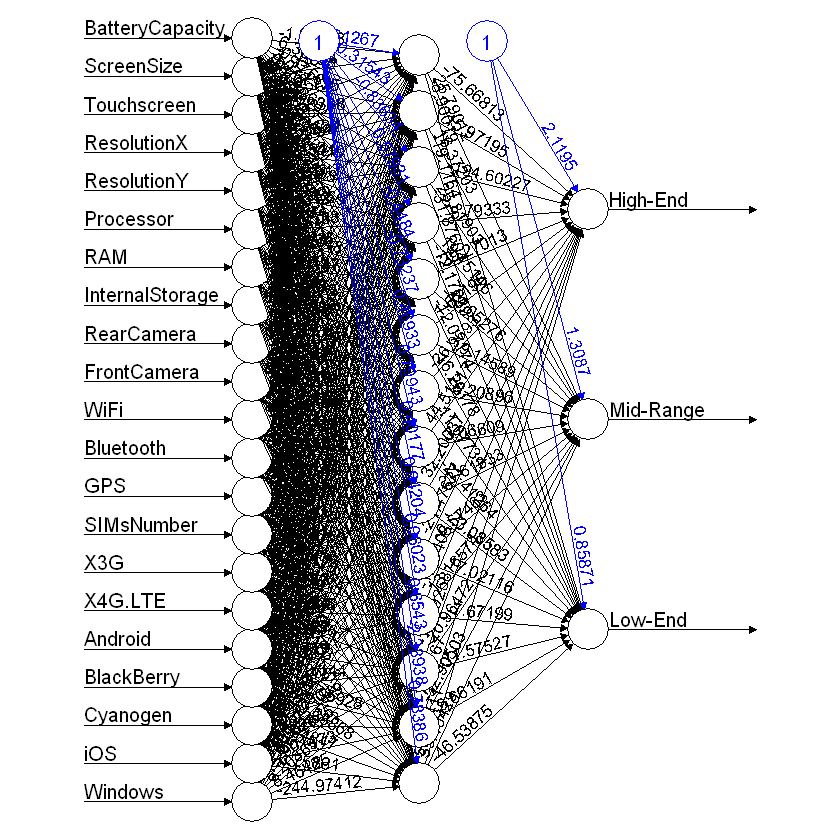

In [10]:
plot(nn, rep=1)

In [11]:
predictions <- neuralnet::compute(nn, rep = 1, testData[, -23])

pred <- predictions$net.result

pred <- data.frame("pred" = ifelse(max.col(pred[ ,1:3]) == 1, 'High-End',
                            ifelse(max.col(pred[ ,1:3]) == 2, 'Low-End', 'Mid-Range')))

cm <- confusionMatrix(as.factor(testData$PriceCategory), as.factor(pred$pred))
 
print(cm)

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         6       2         4
  Low-End          0     240         4
  Mid-Range        8       8        20

Overall Statistics
                                         
               Accuracy : 0.911          
                 95% CI : (0.8723, 0.941)
    No Information Rate : 0.8562         
    P-Value [Acc > NIR] : 0.003237       
                                         
                  Kappa : 0.6712         
                                         
 Mcnemar's Test P-Value : 0.197897       

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.42857         0.9600          0.71429
Specificity                  0.97842         0.9048          0.93939
Pos Pred Value               0.50000         0.9836          0.55556
Neg Pred Value               0.97143         0.7917          0.96875
Prevalence              

#### Drugi ANN model --> train(method='nnet')

In [ ]:
# Second ANN model with train() function
set.seed(1)

train_index <- createFolds(trainData$PriceCategory, k = 10)

nnetFit <- phoneData %>% train(PriceCategory ~ .,
    method = 'nnet',
    data = .,
    tuneLength = 5,
    trControl = trainControl(method = 'cv', indexOut = train_index),
    trace = FALSE)

nnetFit

Neural Network 

1170 samples
  21 predictor
   3 classes: 'High-End', 'Low-End', 'Mid-Range' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1052, 1052, 1053, 1054, 1054, 1052, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa    
  1     0e+00  0.8884726  0.6709041
  1     1e-04  0.8760237  0.5611517
  1     1e-03  0.8792644  0.6254778
  1     1e-02  0.8781536  0.6244270
  1     1e-01  0.8792899  0.6195292
  3     0e+00  0.9007929  0.7061318
  3     1e-04  0.9078186  0.7347591
  3     1e-03  0.9111627  0.7375155
  3     1e-02  0.9156699  0.7424988
  3     1e-01  0.9133847  0.7329313
  5     0e+00  0.9396905  0.8014908
  5     1e-04  0.9339306  0.8019521
  5     1e-03  0.9282880  0.7814341
  5     1e-02  0.9407497  0.8236120
  5     1e-01  0.9339571  0.7997686
  7     0e+00  0.9373537  0.8034415
  7     1e-04  0.9396775  0.8214573
  7     1e-03  0.9519973  0.8587739
  7     1e-02  0.9441852  0.8330079
  7     1e-01  

In [146]:
pr <- predict(nnetFit, testData)
confusionMatrix(pr, reference = as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         9       0         2
  Low-End          2     242         2
  Mid-Range        1       2        32

Overall Statistics
                                          
               Accuracy : 0.9692          
                 95% CI : (0.9423, 0.9858)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 3.31e-13        
                                          
                  Kappa : 0.8898          
                                          
 Mcnemar's Test P-Value : 0.5062          

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.75000         0.9918           0.8889
Specificity                  0.99286         0.9167           0.9883
Pos Pred Value               0.81818         0.9837           0.9143
Neg Pred Value               0.98932         0.9565           0.9844
Prevalence     

## 3. Ansambli - slučajne šume

In [110]:
# Random forest only recive numerical and logical data as the input
# so we convert categorical data to logical TRUE/FALSE

phoneData_rf <- phoneData %>%
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE), ~as.logical(ifelse(.x == 'Yes', TRUE, FALSE))))

#### Prvi model slučajnih šuma --> train(method='rf')

In [111]:
set.seed(1)

trainIndex = createDataPartition(phoneData_rf$PriceCategory, p = 0.75, list = FALSE)
trainData <- phoneData_rf[trainIndex, ]
testData <- phoneData_rf[-trainIndex, ]

train_index <- createFolds(trainData$PriceCategory, k = 10)

rf_model1 <- trainData %>% train(PriceCategory ~ .,
    method = 'rf',
    data = .,
    tuneLength = 5,
    trControl = trainControl(method = 'cv', indexOut = train_index))

rf_model1

Random Forest 

878 samples
 21 predictor
  3 classes: 'High-End', 'Low-End', 'Mid-Range' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 789, 790, 791, 790, 789, 791, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9420268  0.7679104
   6    0.9908948  0.9678357
  11    0.9897454  0.9636043
  16    0.9885960  0.9597307
  21    0.9897196  0.9635986

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

In [112]:
prediction_rf1 <- predict(rf_model1, testData)
confusionMatrix(prediction_rf1, as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         5       0         5
  Low-End          0     239         6
  Mid-Range        7       5        25

Overall Statistics
                                          
               Accuracy : 0.9212          
                 95% CI : (0.8842, 0.9494)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 1.335e-05       
                                          
                  Kappa : 0.7205          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.41667         0.9795          0.69444
Specificity                  0.98214         0.8750          0.95312
Pos Pred Value               0.50000         0.9755          0.67568
Neg Pred Value               0.97518         0.8936          0.95686
Prevalence     

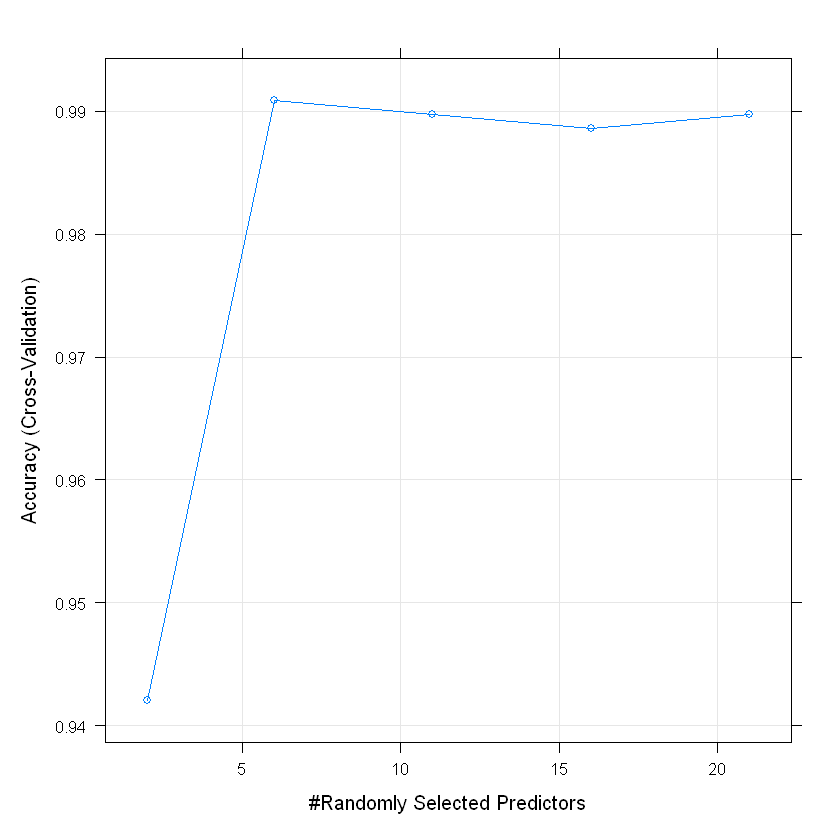

In [147]:
plot(rf_model1)

#### Drugi model slučajnih šuma --> randomForest paket

In [141]:
rf_model2 <- randomForest(x = trainData[-22], y = as.factor(trainData$PriceCategory), ntree = 600)
rf_model2


Call:
 randomForest(x = trainData[-22], y = as.factor(trainData$PriceCategory),      ntree = 600) 
               Type of random forest: classification
                     Number of trees: 600
No. of variables tried at each split: 4

        OOB estimate of  error rate: 8.54%
Confusion matrix:
          High-End Low-End Mid-Range class.error
High-End        16       6        15  0.56756757
Low-End          2     720        11  0.01773533
Mid-Range        5      36        67  0.37962963

In [142]:
predictions_rf2 = predict(rf_model2, testData[-22])
  
confusionMatrix(predictions_rf2, as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         5       0         3
  Low-End          1     240         8
  Mid-Range        6       4        25

Overall Statistics
                                          
               Accuracy : 0.9247          
                 95% CI : (0.8882, 0.9522)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 5.596e-06       
                                          
                  Kappa : 0.7225          
                                          
 Mcnemar's Test P-Value : 0.343           

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.41667         0.9836          0.69444
Specificity                  0.98929         0.8125          0.96094
Pos Pred Value               0.62500         0.9639          0.71429
Neg Pred Value               0.97535         0.9070          0.95720
Prevalence     

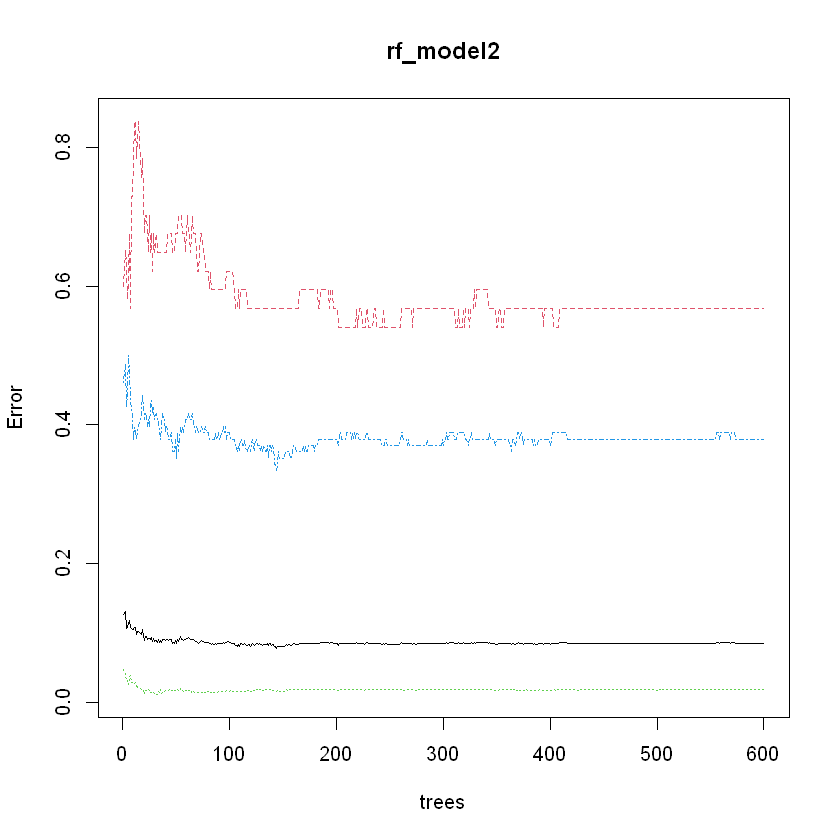

In [143]:
plot(rf_model2)

In [144]:
importance(rf_model2)

,MeanDecreaseGini
BatteryCapacity,17.02202164
ScreenSize,18.34866368
Touchscreen,0.01293395
ResolutionX,22.86650021
ResolutionY,37.33413842
Processor,7.14002169
RAM,22.02593862
InternalStorage,26.65974442
RearCamera,22.38503055
FrontCamera,31.17916206


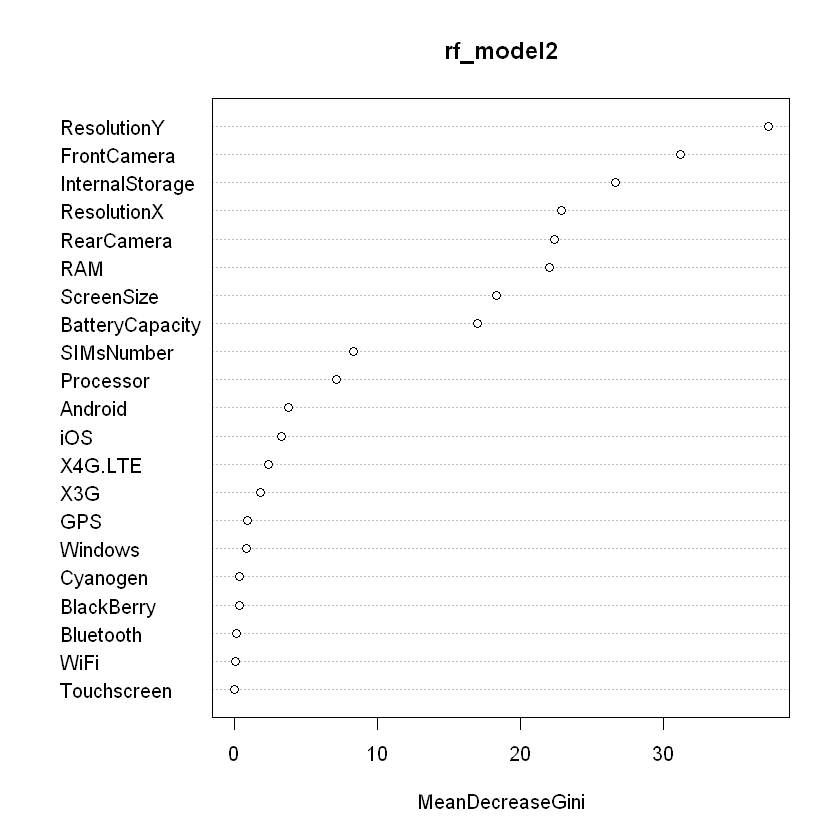

In [145]:
varImpPlot(rf_model2)

## 4. Asocijacijska analiza - učenje asocijacijskih pravila

## 5. Grupiranje k-sredina